In [1]:
import pymc3
import GPy

In [6]:
import numpy as np
import matplotlib.pyplot as pl

# Test data
n = 50
Xtest = np.linspace(-5, 5, n).reshape(-1,1)

# Define the kernel function
def kernel(a, b, param):
    sqdist = np.sum(a**2,1).reshape(-1,1) + np.sum(b**2,1) - 2*np.dot(a, b.T)
    return np.exp(-.5 * (1/param) * sqdist)

param = 0.1
K_ss = kernel(Xtest, Xtest, param)

# Get cholesky decomposition (square root) of the
# covariance matrix
L = np.linalg.cholesky(K_ss + 1e-15*np.eye(n))
# Sample 3 sets of standard normals for our test points,
# multiply them by the square root of the covariance matrix
samples = np.random.normal(size=(n,3))
f_prior = np.dot(L, samples)

In [15]:
print(L.shape)
print(samples.shape)

(50, 50)
(50, 3)


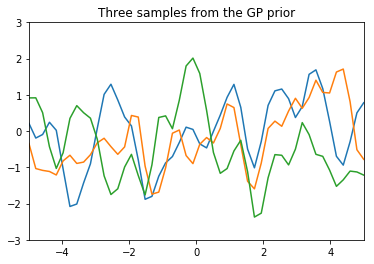

In [3]:
# Now let's plot the 3 sampled functions.
pl.plot(Xtest, f_prior)
pl.axis([-5, 5, -3, 3])
pl.title('Three samples from the GP prior')
pl.show()

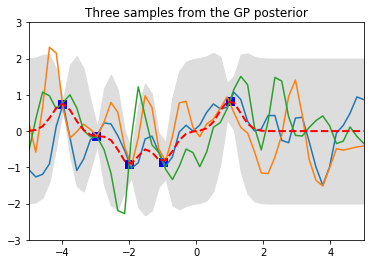

In [16]:
# Noiseless training data
Xtrain = np.array([-4, -3, -2, -1, 1]).reshape(5,1)
ytrain = np.sin(Xtrain)

# Apply the kernel function to our training points
K = kernel(Xtrain, Xtrain, param)
L = np.linalg.cholesky(K + 0.00005*np.eye(len(Xtrain)))

# Compute the mean at our test points.
K_s = kernel(Xtrain, Xtest, param)
Lk = np.linalg.solve(L, K_s)
mu = np.dot(Lk.T, np.linalg.solve(L, ytrain)).reshape((n,))

# Compute the standard deviation so we can plot it
s2 = np.diag(K_ss) - np.sum(Lk**2, axis=0)
stdv = np.sqrt(s2)
# Draw samples from the posterior at our test points.
L = np.linalg.cholesky(K_ss + 1e-6*np.eye(n) - np.dot(Lk.T, Lk))
f_post = mu.reshape(-1,1) + np.dot(L, np.random.normal(size=(n,3)))

In [26]:
print(
"""
L: {}
Xtrain: {}
Xtest: {}
ytrain: {}
kernel between (Xtrain, Xtrain), K: {}
Cholesky decomp L: {}
kernel between (Xtrain, Xtest), K_s: {}
Lk: {}
mu: {}
""".format(
    L.shape,
    Xtrain.shape,
    Xtest.shape,
    ytrain.shape,
    K.shape,
    L.shape,
    K_s.shape,
    Lk.shape,
    mu.shape
)
)


L: (50, 50)
Xtrain: (5, 1)
Xtest: (50, 1)
ytrain: (5, 1)
kernel between (Xtrain, Xtrain), K: (5, 5)
Cholesky decomp L: (50, 50)
kernel between (Xtrain, Xtest), K_s: (5, 50)
Lk: (5, 50)
mu: (50,)



In [ ]:
pl.plot(Xtrain, ytrain, 'bs', ms=8)
pl.plot(Xtest, f_post)
pl.gca().fill_between(Xtest.flat, mu-2*stdv, mu+2*stdv, color="#dddddd")
pl.plot(Xtest, mu, 'r--', lw=2)
pl.axis([-5, 5, -3, 3])
pl.title('Three samples from the GP posterior')
pl.show()